In [741]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from BTplatform import DataLoader
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from IPython.display import FileLink
import seaborn as sns
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [799]:
class EDA:
    def __init__(self, DataLoader):
        self.loader = DataLoader

    def getACF(self, save = False, graph = True, lag = 20, ncols = 3, conf = True):
        '''
        returns the ACFs of all stocks at this timestep for the last 20 lags and graphs all of them.
        '''
        # error handling
        if lag < 1 or isinstance(lag, int) == False:
            raise ValueError('lag must be integer greater than 1')

        # get data and making acfs array
        data = self.loader.returnsToNow() # all returns of required stocks for last lags + today
        acfs = []

        if graph:
            ncols = max(1, int(ncols))
            nrows = math.ceil(self.loader.nins / ncols)
            fig, axes = subplots(nrows, ncols, figsize = (4 * ncols, 3 * nrows), sharex = True, sharey = True) # same x/y axis
            axes = np.atleast_1d(axes).ravel() # atleast_1d --> if its 1d it makes it 2d by chucking brackets around it
            # ravel so can go axes[i] and put them one by one

        for i in range(self.loader.nins):
            stock = data[:, i] # stock data for one stock

            # getting acfs and confidence intervals
            acf_vals = acf(stock, nlags = lag, fft=False, missing='conservative') # dont take shortcut and take out NAs
            acfs.append(acf_vals)

            if graph:
                ax = axes[i]
                ax.axhline(0, c = 'k', lw = 0.5)
                ax.bar(np.arange(lag + 1), acf_vals, width = 0.3, align = 'center') # align puts it at the lag (center)
                ax.plot(acf_vals, lw = 0.5, c = 'r')
                if conf:
                    bound = 1.96 / np.sqrt(len(stock))
                    ax.fill_between(np.arange(lag + 1), -bound, bound, alpha = 0.1, color = 'm')
                ax.set_title(f'Stock {self.loader.stocks[i]}')
                ax.set_xlabel('Lags')
                ax.set_ylabel('ACF')
                ax.set_xlim(0, lag)
        if graph:
            for j in range(self.loader.nins, len(axes)):
                fig.delaxes(axes[j]) # removes the axes that weren't used
            fig.tight_layout() # adjust so titles dont collide and squeeze shit in
            fig.subplots_adjust(top = 1) # leave room for title

            # if saving file for algo presentation
            if save:
                fig.savefig("ACF_plots.png")
                print(FileLink("ACF_plots.png"))
                
        return np.vstack(acfs)

    def getPACF(self, save = False, graph = True, lag = 20, ncols = 3, conf = True):
        '''
        returns the pACFs of all stocks at this timestep for the last 20 lags and graphs all of them.
        '''
        # error handling
        if lag < 1 or isinstance(lag, int) == False:
            raise ValueError('lag must be integer greater than 1')

        # get data and making acfs array
        data = self.loader.returnsToNow() # all returns of required stocks for last lags + today
        pacfs = []

        if graph:
            ncols = max(1, int(ncols))
            nrows = math.ceil(self.loader.nins / ncols)
            fig, axes = subplots(nrows, ncols, figsize = (4 * ncols, 3 * nrows), sharex = True, sharey = True) # same x/y axis
            axes = np.atleast_1d(axes).ravel() # atleast_1d --> if its 1d it makes it 2d by chucking brackets around it
            # ravel so can go axes[i] and put them one by one

        for i in range(self.loader.nins):
            stock = data[:, i] # stock data for one stock

            # getting acfs and confidence intervals
            pacf_vals = pacf(stock, nlags = lag) # dont take shortcut and take out NAs
            pacfs.append(pacf_vals)

            if graph:
                ax = axes[i]
                ax.axhline(0, c = 'k', lw = 0.5)
                ax.bar(np.arange(lag + 1), pacf_vals, width = 0.3, align = 'center') # align puts it at the lag (center)
                ax.plot(pacf_vals, lw = 0.5, c = 'r')
                if conf:
                    bound = 1.96 / np.sqrt(len(stock))
                    ax.fill_between(np.arange(lag + 1), -bound, bound, alpha = 0.1, color = 'm')
                ax.set_title(f'Stock {self.loader.stocks[i]}')
                ax.set_xlabel('Lags')
                ax.set_ylabel('PACF')
                ax.set_xlim(0, lag)
        if graph:
            for j in range(self.loader.nins, len(axes)):
                fig.delaxes(axes[j]) # removes the axes that weren't used
            fig.tight_layout() # adjust so titles dont collide and squeeze shit in
            fig.subplots_adjust(top = 1) # leave room for title

            # if saving file for algo presentation
            if save:
                fig.savefig("PACF_plots.png")
                print(FileLink("PACF_plots.png"))
                
        return np.vstack(pacfs)

    def getADF(self, log = True):
        '''
        uses adf to check for weak stationality
        '''
        returnSeries = self.loader.returnsToNow(log).T # getting returns til now (set t to end)
        
        print('ADF statistics!!')
        for i, price in enumerate(returnSeries):
            results = adfuller(price) # gettting ts, read docs
            
            p = results[1]
            if p < 0.05:    
                print(f'''# Stock {self.loader.stocks[i]} ####################
                ADF statistic: {results[0]}
                Mackinnon p value: {results[1]}
                Observations used: {results[3]}
                Crit. values: {results[4]}''') # mackinnon p value make sure < 0,05

    def plotReturns(self, log = True, ncols = 1):
        '''
        plots the returns of all stocks in dataloader -> useful to check if further differencing is required, visual conf of adf.
        '''
        returnSeries = self.loader.returnsToNow(log).T # getting returns til now (set t to end)
        ncols = max(1, ncols)
        nrows = math.ceil(self.loader.nins/ncols)
        fig, axes = subplots(nrows, ncols, figsize = (16 * ncols, 3 * nrows), sharex = True, sharey = True)
        axes = np.atleast_1d(axes).ravel()
        
        for i, price in enumerate(returnSeries):
            ax = axes[i]
            ax.plot(price)
            ax.set_title(f'Stock {self.loader.stocks[i]}')
            ax.axhline(0, c = 'r', ls = '--')

        for j in range(self.loader.nins, len(axes)):
            fig.delaxes(axes[j]) # removes the axes that weren't used
            fig.tight_layout() # adjust so titles dont collide and squeeze shit in
            fig.subplots_adjust(top = 1) # leave room for title

    def fitARIMA(self, params, train_len = 0.8, ncols = 1, log = True):
        '''
        params is (p, d, q)
        Fits arma model and plots the predicted vs test
        '''
        returnSeries = self.loader.returnsToNow(log).T # getting returns til now (set t to the end)

        for i, price in enumerate(returnSeries):
            n_train = int(train_len) if train_len > 1 else int(self.loader.t * train_len)
            train = price[:n_train]
            test = price[n_train:]
        
            model = SARIMAX(train, order=params).fit(disp=False)
            print(f'''
            # Stock {self.loader.stocks[i]}  ####################
            {model.summary()}
            ''')
            pred = model.predict(start=n_train, end=self.loader.t, dynamic=False) # dynamic = false if we know past values

    def backtestARIMA(self, params, train_len = 0.8, warning = False, save = True, ncols = 1, log = True):
        '''
        same settings as fitARIMA
        arima plotter
        backtests and gets root mean square error
        '''
        returnSeries = self.loader.returnsToNow(log).T # getting returns

        # graph matrix settings
        ncols = max(1, ncols)
        nrows = math.ceil(self.loader.nins/ncols)
        fig, axes = subplots(nrows, ncols, figsize = (16 * ncols, 3 * nrows), sharex = True)
        axes = np.atleast_1d(axes).ravel()
        
        for i, price in enumerate(returnSeries):
            ax = axes[i]

            # initial training window
            n_train = int(train_len) if train_len > 1 else int(self.loader.t * train_len)

            preds = []
            errors = []
            for t in range(n_train, self.loader.t):
                y_train = price[:t]

                # getting rid of stupid warnings 
                if warning == False:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=ConvergenceWarning)
                        warnings.simplefilter("ignore", category=RuntimeWarning)

                        model = SARIMAX(y_train, order=params).fit(disp=False)
                else:
                    model = SARIMAX(y_train, order=params).fit(disp=False)
                pred = model.predict(start = len(y_train), end = len(y_train), dynamic = False) # dynamic = false if we know past values
                preds.append(pred)
                true_val = price[t]
                errors.append(true_val - pred)
            
            ax.plot(price[:n_train + 1])
            ax.plot(range(n_train, self.loader.t), price[n_train:], color = 'silver')
            ax.plot(range(n_train, self.loader.t), preds, color = 'orange')
            ax.set_title(f'Stock {self.loader.stocks[i]}')
            errors = np.array(errors)
            mae = np.mean(np.abs(errors))
            rmse = np.sqrt(np.mean(errors**2))
            mrmse = rmse/np.std(price) # i dont rlly know the formula for this, keep gettign fucked values so imma not include

            print(f'# Stock {self.loader.stocks[i]} ####################')
            print(f"MAE:  {mae:.6f}")
            print(f"RMSE: {rmse:.6f}")
            print(f"norm. RMSE: {mrmse:.6f}")

        if save:
            fig.savefig('ARIMA_Backtests.png')

In [795]:
prices = np.loadtxt('../Data/StockData.txt')
prices

array([[13.46, 71.65, 48.46, ..., 36.22, 49.  , 56.09],
       [13.48, 72.1 , 48.52, ..., 36.27, 48.84, 56.08],
       [13.47, 72.35, 48.48, ..., 36.39, 48.56, 55.9 ],
       ...,
       [ 8.33, 69.68, 43.38, ..., 30.07, 59.42, 56.23],
       [ 8.25, 70.15, 43.35, ..., 30.07, 59.56, 56.21],
       [ 8.26, 70.93, 43.34, ..., 29.91, 59.12, 56.32]])

# Stock 0 ####################
MAE:  0.005341
RMSE: 0.006774
mRMSE: 1.071043
# Stock 1 ####################
MAE:  0.004523
RMSE: 0.005914
mRMSE: 1.034372
# Stock 2 ####################
MAE:  0.000595
RMSE: 0.000744
mRMSE: 1.099163
# Stock 3 ####################
MAE:  0.001398
RMSE: 0.001820
mRMSE: 1.094639
# Stock 4 ####################
MAE:  0.003504
RMSE: 0.004311
mRMSE: 1.077517
# Stock 5 ####################
MAE:  0.004011
RMSE: 0.005073
mRMSE: 0.846398
# Stock 6 ####################
MAE:  0.001564
RMSE: 0.002033
mRMSE: 1.026982
# Stock 7 ####################
MAE:  0.006965
RMSE: 0.008462
mRMSE: 1.054123
# Stock 8 ####################
MAE:  0.001213
RMSE: 0.001547
mRMSE: 1.092819
# Stock 9 ####################
MAE:  0.008533
RMSE: 0.010365
mRMSE: 1.109713
# Stock 10 ####################
MAE:  0.006305
RMSE: 0.007812
mRMSE: 0.826604
# Stock 11 ####################
MAE:  0.008453
RMSE: 0.010113
mRMSE: 1.001171
# Stock 12 ####################
MAE:  0.001609
RMSE: 0.001959
mRMSE: 0.913

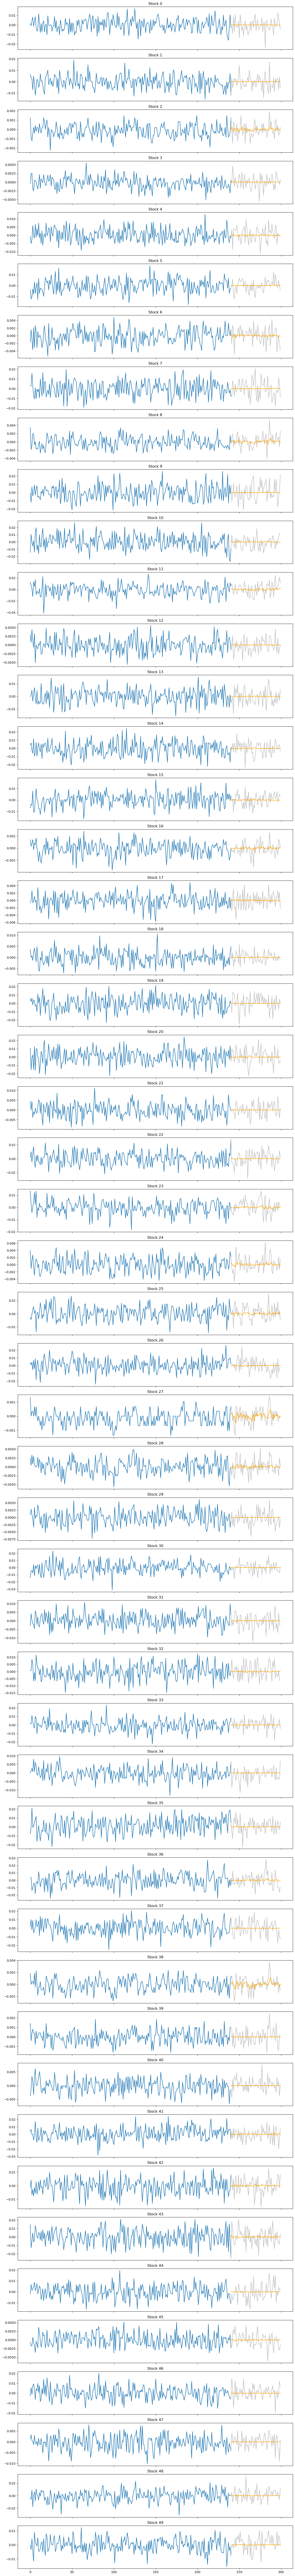

In [797]:
eda = EDA(DataLoader(prices))
eda.loader.t = 300
eda.backtestARIMA([1, 0, 0])